In [1]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as pp

### Import en greyscale et batch-resize simultanés des images :

In [2]:
train_avec = [cv2.imread(file, 0) for file in glob.glob("./data/Dataset_masks/train/with_mask/*.jpg")]
train_sans = [cv2.imread(file, 0) for file in glob.glob("./data/Dataset_masks/train/without_mask/*.jpg")]

test_avec = [cv2.imread(file, 0) for file in glob.glob("./data/Dataset_masks/test/with_mask/*.jpg")]
test_sans = [cv2.imread(file, 0) for file in glob.glob("./data/Dataset_masks/test/without_mask/*.jpg")]

print("longueur de train_avec :",len(train_avec))
print("longueur de train_sans :",len(train_sans))
print("longueur de test_avec :", len(test_avec))
print("longueur de test_sans :", len(test_sans))

longueur de train_avec : 654
longueur de train_sans : 652
longueur de test_avec : 97
longueur de test_sans : 97


### Batch-resizing de nos images :

In [21]:
train_avec = [cv2.resize(file, (100, 100)) for file in train_avec]
train_sans = [cv2.resize(file, (100, 100)) for file in train_sans]
test_avec = [cv2.resize(file, (100, 100)) for file in test_avec]
test_sans = [cv2.resize(file, (100, 100)) for file in test_sans]

On concatène nos features de train avec et sans masque, idem pour nos features de test :

In [4]:
x_train = np.concatenate((np.asarray(train_avec, dtype=list), np.asarray(train_sans, dtype=list)), axis=0)
x_train.shape

(1306, 100, 100)

In [5]:
x_test = np.concatenate((np.asarray(test_avec, dtype=list), np.asarray(test_sans, dtype=list)), axis=0)
x_test.shape

(194, 100, 100)

Création des labels 0 pour sans masque et 1 pour avec masque :

In [6]:
y_train_avec = np.ones((654,))
y_train_sans = np.zeros((652,))

In [7]:
y_test_avec = np.ones((97,))
y_test_sans = np.zeros((97,))

On concatène nos vecteurs colones de labels :

In [8]:
y_train = np.concatenate((np.asarray(y_train_avec), np.asarray(y_train_sans)), axis=0)
y_train.shape

(1306,)

In [9]:
y_test = np.concatenate((np.asarray(y_test_avec), np.asarray(y_test_sans)), axis=0)
y_test.shape

(194,)

### Mélange aléatoire des instances :

On crée un range aléatoire et on mélange les sets avec :

In [10]:
range_aleatoire = np.random.permutation(1306)
x_train_r = x_train[range_aleatoire]
y_train_r = y_train[range_aleatoire]

In [11]:
range_aleatoire = np.random.permutation(194)
x_test_r = x_test[range_aleatoire]
y_test_r = y_test[range_aleatoire]

Visualisation des classes :

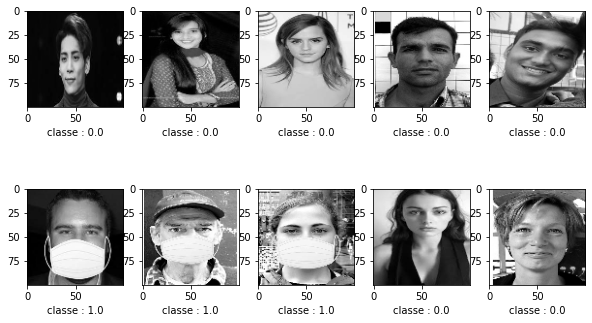

In [12]:
pp.figure(figsize=(10,6))
for i in range(10):
    pp.subplot(2,5,i+1)
    pp.imshow(np.uint8(x_test_r[i]), cmap='gray')
    pp.xlabel("classe : {}".format(y_test_r[i]))
pp.show()

### Standardisation des données 

In [13]:
x_train_r_s = x_train_r.astype('float')/255
x_test_r_s = x_test_r.astype('float')/255

In [14]:
x_train_r_s = x_train_r_s.reshape(-1,100,100,1)
x_test_r_s = x_test_r_s.reshape(-1,100,100,1)

In [15]:
x_test_r_s.shape

(194, 100, 100, 1)

### Constitution du modèle CNN

In [16]:
import tensorflow as tf

In [31]:
# On instancie notre modèle keras séquentiel :
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, 3,
                                 padding="same",
                                 activation='relu',
                                 input_shape=(100, 100, 1)))
model.add(tf.keras.layers.Conv2D(64, 3,
                                 padding="same",
                                 activation='relu'))


model.add(tf.keras.layers.MaxPooling2D(2))

model.add(tf.keras.layers.Conv2D(128, 3,
                                 padding="same",
                                 activation='relu'))

model.add(tf.keras.layers.Conv2D(128, 3,
                                 padding="same",
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(2))


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(.25))


model.add(tf.keras.layers.Dense("1", activation='sigmoid'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 64)      640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)            

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history = model.fit(x_train_r_s,
                    y_train_r,
                    batch_size=5,
                    epochs=3,
                    validation_split=0.2)

Epoch 1/3
209/209 [==============================] - 97s 460ms/step - loss: 0.6920 - accuracy: 0.5632 - val_loss: 0.4383 - val_accuracy: 0.8244
Epoch 2/3
209/209 [==============================] - 95s 454ms/step - loss: 0.4662 - accuracy: 0.8012 - val_loss: 0.2737 - val_accuracy: 0.8817
Epoch 3/3
209/209 [==============================] - 96s 458ms/step - loss: 0.3329 - accuracy: 0.8828 - val_loss: 0.2440 - val_accuracy: 0.9046


In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(x_test_r_s)> 0.5).astype("int32")

print(confusion_matrix(y_test_r, y_pred), "accuracy_score :", accuracy_score(y_test_r, y_pred).round(4))


[[75 22]
 [ 2 95]] accuracy_score : 0.8763


In [21]:
model.save('./')

INFO:tensorflow:Assets written to: ./assets


## Détection sur flux vidéo

On peut à présent utiliser notre modèle en mode online avec de la prédiction sur frames de flux vidéo. Pour ce faire, on va utiliser la classe VideoCapture de opencv.

In [1]:

import cv2
import numpy as np

import tensorflow as tf
model = tf.keras.models.load_model('./')

Fonction d'affichage des emojis :

In [4]:
def afficher_emote(statut):
    
    if statut == "sad":
        img2 = sad
        
    elif statut == "happy":
        img2 = happy
    
    else : img2 = rien
        
    # Création d'une région d'intérêt openCV au coin supérieur-gauche & de la taille du smiley :
    rows,cols,channels = img2.shape
    roi = im2[0:rows, 0:cols ]

    # Création d'un masque du smiley (et son masque inverse)
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 30, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Black-out du smiley dans la ROI :
    im_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    
    # De l'image du smiley, on ne prend que le smiley en lui-même :
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

    # Ajout du smiley dans le ROI et modification de l'image principale pour intégrer l'ajout :
    dst = cv2.add(im_bg,img2_fg)
    im2[0:rows, 0:cols ] = dst

    return

Programme de détection de masque sur flux video :

In [16]:
sad = cv2.imread('./sad1.png')
happy = cv2.imread('./happy1.png')
rien = cv2.imread('./rien.png')

# Facteur pour le redimensionnement de l'image
imgsize = 4
# Allumage de la webcam : 
camera = cv2.VideoCapture(0)
# Identification d'un visage :
classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Touche pour fermer, initialisée à 0, si elle passe à 27 avec le waitKey(), c'est que l'utilisateur a fait ESC
key=0
while key!=27:
    # Deux variables vont être continuellement remplies via la cam avec la méthode read().
    # rval est un booléen qui atteste du fait que les frames de la cam sont bien lues, im sera notre image vidéo.
    (rval, im) = camera.read()
    # On passe l'image en miroir
    im=cv2.flip(im,1,1)
    
    # Création d'une copie de l'image issue de la webcam
    # La prédiction se fera via im sans le smiley pour éviter qu'il soit reconnu comme un visage:
    im2 = im.copy()
    
    # Redimensionnement à la baisse de l'image récupérée de la webcam (640*480 => 160*120)
    # Objectif : soulaver le classifieur de haar.
    image_redim = cv2.resize(im, (im.shape[1] // imgsize,
                             im.shape[0] // imgsize))
        
    # On crée nos frames de visage reconnu par classifieur haar appliqué aux images issues des frames redimensionnées :
    face_rec = classifier.detectMultiScale(image_redim) 
    # print("face_rec=",face_rec)
    
    # Si le type de face_rec n'est pas tuple, cela veut dire que face_rec != () (càd qu'il n'est pas vide)
    if type(face_rec) != tuple: # faut-il aussi faire "and 0 not in face_rec[0]" ?
        # Pour chaque visage reconnu :
        for i in face_rec:
            # Le classifieur haar travaillait sur images réduites de facteur 4 mais pour découper
            # un médaillon rectangulaire qui correspond au visage détecté sur notre image webcam,
            # il faut à nouveau multiplier les données d'output du classifieur par le imsize :
            (x, y, l, w) = [v * imgsize for v in i]
            # On découpe dans l'image de la caméra avec les coordonnées obtenues grâce à haar.
            face_img = im[y:(y+w), x:(x+l)]
            # On redimensionne :
            face_redim=cv2.resize(face_img,(100,100))
            # On passe en gris :
            face_gray = cv2.cvtColor(face_redim, cv2.COLOR_RGB2GRAY)
            
            # En l'absence d'un modèle entraîné sur un dataset dûment data augmenté
            # avec des doublons d'images aux contrastes et luminosités variées, le
            # réglage de contraste et de brightness pour la prédiction est crucial.
            # Selon l'éclairage dans lequel tourne l'appli et la webcam, il faut régler
            # les deux paramètres suivants.
            # S'il fait sombre, brightness à 2 marche bien, sinon 1.
            
            contrast = 2.5
            brightness = 2.5
            face_contrast = cv2.addWeighted(face_gray, contrast, face_gray, 0, brightness)

            # On standardise la valeur des pixels de l'array :
            face_standardise= face_contrast.astype('float')/255

            # On reshape pour fonctionner avec le CNN :
            face_reshaped = face_standardise.reshape(-1,100,100,1)
            
            afficher_emote(statut="rien")
            prediction = model.predict(face_reshaped)

            # La prédiction sur image issue de flux vidéo fonctionne mais il faut
            # définir un seuil car on atteint pas des taux de certitude de 99%.
            if prediction[0][0] >= 0.6 :
                cv2.putText(im2, "MASK OK", (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255))
                cv2.putText(im2, str(prediction), (200, 300), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255))
                afficher_emote(statut="happy")
            else :
                cv2.putText(im2, "NO MASK", (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255))
                cv2.putText(im2, str(prediction), (200, 300), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255))
                afficher_emote(statut="sad")

               

    # On affiche im2 et pas im pour avoir l'image modifiée avec le smiley :
    cv2.imshow('Detecteur de masques',im2)
    key = cv2.waitKey(10)

camera.release()
cv2.destroyAllWindows()